# Loading the dataframes from the excel file

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import xlrd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from scipy.integrate import odeint
from cycler import cycler

import matplotlib.cm as cm
import subprocess, glob, os
%matplotlib inline

In [2]:
sns.set()
excel_file_name = 'results.xlsx'
statistics = pd.read_excel(excel_file_name, sheet_name='Statistics')
lines_crosses = pd.read_excel(excel_file_name, sheet_name='Lines Crosses')

# Curve of number of vehicles (total) over time

,car_id
time,
0.08333,133
0.12500,133
0.16667,134
0.20833,134
0.25000,134
...,...
239.83333,119
239.87500,120
239.91667,120


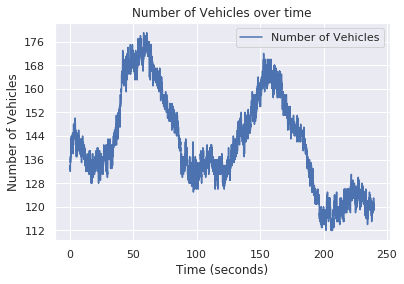

In [3]:
result = statistics.groupby('time')['car_id'].nunique().to_frame()
display(result)
ax = sns.lineplot(data=result)
ax.set_title('Number of Vehicles over time')
ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('Time (seconds)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
L=plt.legend()
L.get_texts()[0].set_text('Number of Vehicles')
plt.show()
figure = ax.get_figure()    
figure.savefig('Nbre_of_vehicles_over_time.png', dpi=400)

# Curve of number of vehicles (per zones)  over time

car_id
time      zone        
0.08333   0         66
          1         25
          2          9
          3          8
          4          3
...                ...
240.00000 3         14
          4          2
          5         19
          6          3
          7          2

[45441 rows x 1 columns]

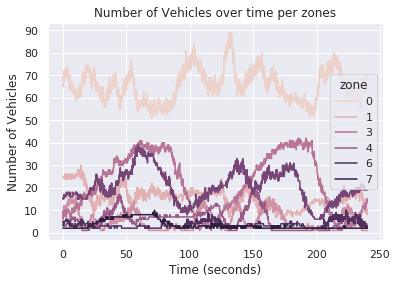

In [4]:
result = statistics.groupby(['time','zone'])['car_id'].nunique().to_frame()
display(result)
ax = sns.lineplot(data=result, x="time", y="car_id", hue="zone")
sns.set_palette("prism")
ax.set_title('Number of Vehicles over time per zones')
ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('Time (seconds)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
figure = ax.get_figure()    
figure.savefig('Nbre of vehicles_per_zones_over_time.png', dpi=400)

# Curve of average velocity (total) for moving vehicles over time

In [5]:
statistics_moving_vehicles = statistics[statistics.velocity > 0]

,velocity
time,
0.12500,27.064516
0.16667,31.039216
0.20833,29.022222
0.25000,29.195745
0.29167,45.805660
...,...
239.83333,24.452381
239.87500,25.128571
239.91667,24.490000


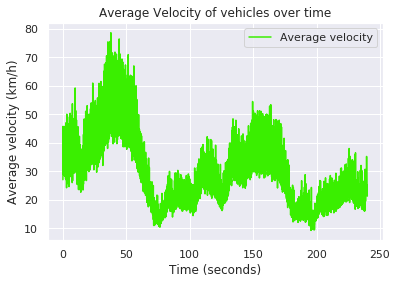

In [6]:
result = statistics_moving_vehicles.groupby('time')['velocity'].mean().to_frame()
display(result)
ax = sns.lineplot(data=result)
ax.set_title('Average Velocity of vehicles over time')
ax.set_ylabel('Average velocity (km/h)')
ax.set_xlabel('Time (seconds)')
L=plt.legend()
L.get_texts()[0].set_text('Average velocity')
plt.show()
figure = ax.get_figure()    
figure.savefig('Average_Velocity_of_vehicles_over_time.png', dpi=400)

# Curve of average velocity (per zone) for moving vehicles over time

velocity
time    zone           
0.125   0     19.895238
        1      8.500000
        2     43.955556
        3     27.857143
        4     57.350000
...                 ...
240.000 1     20.750000
        2     22.100000
        3     11.833333
        4     24.300000
        5     14.000000

[34512 rows x 1 columns]

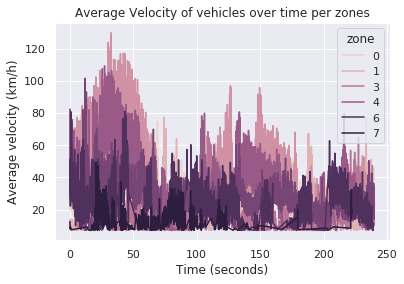

In [7]:
result = statistics_moving_vehicles.groupby(['time','zone'])['velocity'].mean().to_frame()
display(result)
ax = sns.lineplot(data=result, x="time", y="velocity", hue="zone")
ax.set_title('Average Velocity of vehicles over time per zones')
ax.set_ylabel('Average velocity (km/h)')
ax.set_xlabel('Time (seconds)')
plt.show()
figure = ax.get_figure()    
figure.savefig('Average_Velocity_of_vehicles_over_time_per_zones.png', dpi=400)

# Heat map image of the most congested areas

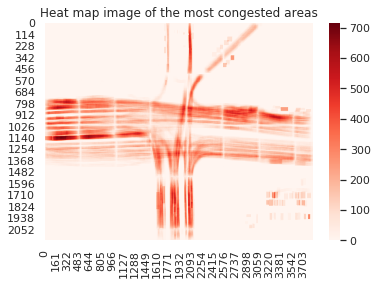

In [8]:
congestion_matrix = np.zeros((3840, 2160))
for index, row in statistics_moving_vehicles.iterrows():
    congestion_matrix[int(row['box0']):int(row['box2']), int(row['box1']):int(row['box3'])] += 1
ax = sns.heatmap(congestion_matrix.T, cmap='Reds')
ax.set_title('Heat map image of the most congested areas')
plt.show()
figure = ax.get_figure()    
figure.savefig('heatmap.png', dpi=400)
figure = ax.get_figure()    
figure.savefig('Heat_map_image_of_the_most_congested_areas.png', dpi=400)

# Heat map of the average velocity per pixel (The average velocity took by every vehicle in every portion of the road)

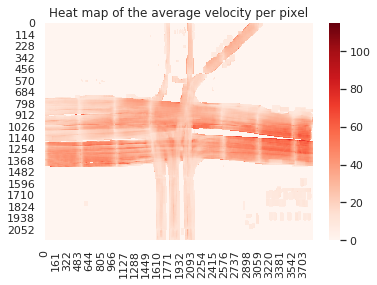

In [9]:
average_velocity_matrix = np.zeros((3840, 2160))
for index, row in statistics_moving_vehicles.iterrows():
    average_velocity_matrix[int(row['box0']):int(row['box2']), int(row['box1']):int(row['box3'])] += int(row['velocity'])
congestion_matrix[congestion_matrix == 0] = 1
average_velocity_matrix = np.divide(average_velocity_matrix, congestion_matrix)
ax = sns.heatmap(average_velocity_matrix.T, cmap='Reds')
ax.set_title('Heat map of the average velocity per pixel')
plt.show()
figure = ax.get_figure()
figure.savefig('heatmap_velocity.png', dpi=400)
figure = ax.get_figure()    
figure.savefig('Heat_map_of_the_average_velocity_per_pixel.png', dpi=400)

# Heat map of the maximum velocity recorded per pixel

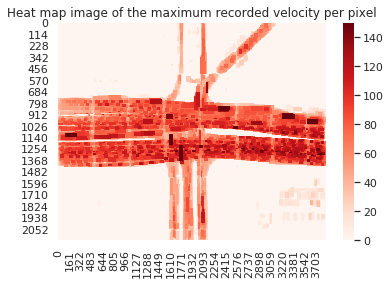

In [10]:
max_velocity_matrix = np.zeros((3840, 2160))
for index, row in statistics_moving_vehicles.iterrows():
    matrix = max_velocity_matrix[int(row['box0']):int(row['box2']), int(row['box1']):int(row['box3'])]
    matrix[matrix < int(row['velocity'])] = int(row['velocity'])
    max_velocity_matrix[int(row['box0']):int(row['box2']), int(row['box1']):int(row['box3'])] = matrix
max_velocity_matrix[max_velocity_matrix>150] =150
ax = sns.heatmap(max_velocity_matrix.T, cmap='Reds')
ax.set_title('Heat map image of the maximum recorded velocity per pixel')
plt.show()
figure = ax.get_figure()
figure.savefig('heatmap_velocity.png', dpi=400)
figure = ax.get_figure()    
figure.savefig('Heat_map_image_of_the_maximum_recorded_velocity_per_pixel.png', dpi=400)

# The trajectories of vehicles

In [11]:
trajectories = []
x = []
y = []
for i in range(statistics_moving_vehicles['car_id'].max()+1):
    trajectories.append([])
    x.append([])
    y.append([])
for index, row in statistics_moving_vehicles.iterrows():
    trajectories[int(row['car_id'])].append((int(row['center_box_x']),int(row['center_box_y'])))
    x[int(row['car_id'])].append(int(row['center_box_x']))
    y[int(row['car_id'])].append(int(row['center_box_y']))


In [12]:
trajectories = [o for o in trajectories if o]
x = [o for o in x if o]
y = [o for o in y if o]

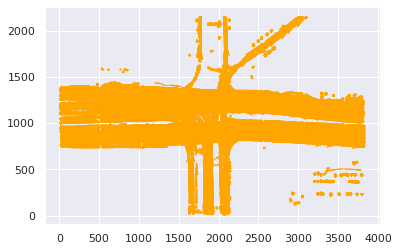

In [15]:
plt.figure()
for index in range(len(x)):
    one_traj_x = np.array(x[index])
    one_traj_y = np.array(y[index])
    one_traj_y = 2160 - one_traj_y
    ax = plt.quiver(one_traj_x[:-1], one_traj_y[:-1], one_traj_x[1:]-one_traj_x[:-1], one_traj_y[1:]-one_traj_y[:-1], scale_units='xy', angles='xy', scale=1, color='Orange')
plt.show()
figure = ax.get_figure()    
figure.savefig('The_trajectories_of_vehicles.png', dpi=400)

# Statitc crossroads management: studying the movement of vehicles between zones.

In [16]:
moving_vehicles_between_zones = statistics_moving_vehicles[statistics_moving_vehicles.zone > 0]
result = moving_vehicles_between_zones.groupby(['car_id'])['zone'].unique().to_frame()
final_result = pd.DataFrame()
for index, row in result.iterrows():
    if(len(row['zone']) > 1 ):
        final_result = final_result.append(result.loc[index])
movement_matrix = a = np.zeros(shape=(7,7), dtype=int) 
for index, row in final_result.iterrows():
    movement_matrix[row['zone'][0]-1,row['zone'][1]-1] += 1
print(movement_matrix*100//45)

[[ 0  0  0  0 26  8  0]
 [ 0  0  0  0  0  0  0]
 [ 0 17  0  0 15  6  0]
 [ 0 24  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0]]


# Probability density of vehicle sizes for the total video

,car_id
area,
0.2,0.000001
0.3,0.000001
0.4,0.000002
0.5,0.000002
0.6,0.000027
...,...
102.1,0.000001
104.2,0.000001
104.4,0.000001


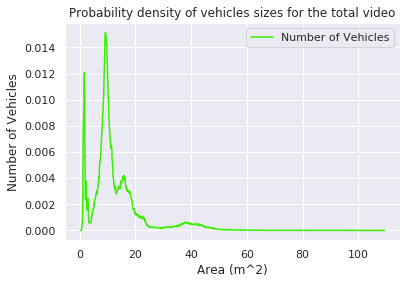

In [17]:
result = statistics.groupby('area')['car_id'].count().to_frame()
car_count = np.sum(result.car_id)
result['car_id'] = result['car_id']/car_count
display(result)
ax = sns.lineplot(data=result)
ax.set_title('Probability density of vehicles sizes for the total video')
ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('Area (m^2)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
L=plt.legend()
L.get_texts()[0].set_text('Number of Vehicles')
plt.show()
figure = ax.get_figure()    
figure.savefig('Probability_density_of_vehicles_sizes_for_the_total_video.png', dpi=400)

# Histogram of vehicle sizes per frame over time

In [ ]:
i =0
#time_value = 8.333e-02
for time_value in statistics.time.unique():
    result = statistics[statistics['time']==time_value]
    result = result.groupby('area')['car_id'].nunique().to_frame()
    car_count = np.sum(result.car_id)
    result['car_id'] = result['car_id']/car_count
    plt.clf()
    ax = sns.histplot(data=result, x='area')
    ax.set_title('Histogram of vehicles sizes for the video on time:' + str(round(time_value,1)) +'s')
    ax.set_ylabel('Number of Vehicles')
    ax.set_xlabel('Area (m^2)')
    ax.set(xlim=(0, 70))
    ax.set(ylim=(0, 30))
    plt.savefig("/home/bilel/1-demos/deep_sort_yolov3_smart_crossroads/video_frames/file%05d.png" % i)
    i+=1

os.chdir("/home/bilel/1-demos/deep_sort_yolov3_smart_crossroads/video_frames/")
subprocess.call([
    'ffmpeg', '-framerate', '8', '-i', 'file%05d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'Histogram_of_vehicle_size_per_frame.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)

# Curve of average size of vehicles per time 

In [ ]:
result = statistics.groupby('time')['area'].mean().to_frame()
#car_count = np.sum(result.car_id)
#result['car_id'] = result['car_id']/car_count
display(result)
ax = sns.lineplot(data=result)
ax.set_title('Average size of vehicles over time')
ax.set_ylabel('Average size (m^2)')
ax.set_xlabel('Time (s)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
L=plt.legend()
L.get_texts()[0].set_text('Average size (m^2)')
plt.show()
figure = ax.get_figure()    
figure.savefig('Average_size_of_vehicles_over_time.png', dpi=400)

# Histogram of vehicle velocity per frame over time

In [ ]:
i =0
for time_value in statistics.time.unique():
    result = statistics[statistics['time']==time_value]
    result = result.groupby('velocity')['car_id'].nunique().to_frame()
    plt.clf()
    ax = sns.histplot(data=result, x='velocity')
    ax.set_title('Histogram of vehicles velocity for the video on time:' + str(round(time_value,1)) +'s')
    ax.set_ylabel('Number of Vehicles')
    ax.set_xlabel('Velocity (km/h)')
    ax.set(xlim=(0, 140))
    ax.set(ylim=(0, 25))
    plt.savefig("/home/bilel/1-demos/deep_sort_yolov3_smart_crossroads/video_frames/file%05d.png" % i)
    i+=1
os.chdir("/home/bilel/1-demos/deep_sort_yolov3_smart_crossroads/video_frames/")
subprocess.call([
    'ffmpeg', '-framerate', '24', '-i', 'file%05d.png', '-r', '24', '-pix_fmt', 'yuv420p',
    'Histogram_of_vehicle_velocities_per_frame.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)

# Probability density of vehicle velocity for the total video

,car_id
velocity,
7.0,0.002844
7.1,0.002850
7.2,0.002819
7.3,0.002812
7.4,0.002875
...,...
168.5,0.000006
170.5,0.000006
176.7,0.000006


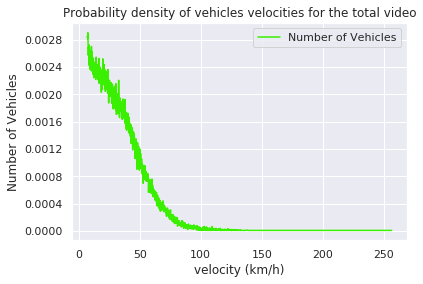

In [19]:
result = statistics[statistics['velocity']>0].groupby('velocity')['car_id'].nunique().to_frame()
car_count = np.sum(result.car_id)
result['car_id'] = result['car_id']/car_count
display(result)
ax = sns.lineplot(data=result)
ax.set_title('Probability density of vehicles velocities for the total video')
ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('velocity (km/h)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
L=plt.legend()
L.get_texts()[0].set_text('Number of Vehicles')
plt.show()
figure = ax.get_figure()    
figure.savefig('Probability_density_of_vehicles_velocities_for_the_total_video.png', dpi=400)

# Correlation between average vehicle size,  average velocity and  number of vehicles over time

,velocity,area,car_id
time,,,
0.12500,27.064516,15.251613,62
0.16667,31.039216,17.021569,51
0.20833,29.022222,16.666667,54
0.25000,29.195745,18.091489,47
0.29167,45.805660,17.856604,53
...,...,...,...
239.83333,24.452381,7.357143,21
239.87500,25.128571,9.266667,21
239.91667,24.490000,8.665000,20


          velocity      area    car_id
velocity  1.000000 -0.401164  0.706777
area     -0.401164  1.000000 -0.393587
car_id    0.706777 -0.393587  1.000000


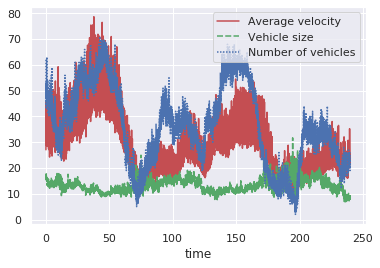

In [21]:
result1 = statistics[statistics['velocity']>0].groupby('time')['velocity'].mean().to_frame()
#display(result1)
result2 = statistics[statistics['velocity']>0].groupby('time')['area'].mean().to_frame()
#display(result2)
result3 = statistics[statistics['velocity']>0].groupby('time')['car_id'].nunique().to_frame()
result_final = result1.join(result2).join(result3)
display(result_final)
ax = sns.lineplot(data=result_final)
L=plt.legend()
L.get_texts()[0].set_text('Average velocity')
L.get_texts()[1].set_text('Vehicle size')
L.get_texts()[2].set_text('Number of vehicles')
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y'])))
column_1 = result_final["velocity"]
column_2 = result_final["area"]
correlation_df = result_final.corr(method='pearson')
final_table_sheet1 = result_final
print(correlation_df)
plt.show()
figure = ax.get_figure()    
figure.savefig('Correlation_1.png', dpi=400)

# Curves of allowed and forbidden crosses over time

,time,Allowed Crosses,Forbidden Crosses,New Allowed Crosses,New Forbidden Crosses,Time in seconds
0,0.00000,0,0,0.0,0.0,0.0
1,0.04167,0,0,0.0,0.0,0.0
2,0.08333,1,0,1.0,0.0,0.0
3,0.12500,2,0,1.0,0.0,0.0
4,0.16667,2,0,0.0,0.0,0.0
...,...,...,...,...,...,...
5756,239.83333,664,150,0.0,0.0,239.0
5757,239.87500,664,150,0.0,0.0,239.0
5758,239.91667,664,150,0.0,0.0,239.0
5759,239.95833,664,150,0.0,0.0,239.0


,New Allowed Crosses,New Forbidden Crosses
time,,
0.00000,0.0,0.0
0.04167,0.0,0.0
0.08333,1.0,0.0
0.12500,1.0,0.0
0.16667,0.0,0.0
...,...,...
239.83333,0.0,0.0
239.87500,0.0,0.0
239.91667,0.0,0.0


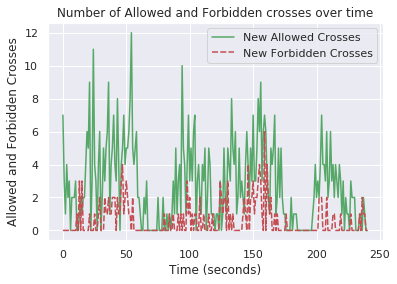

In [23]:
# real order: 6+(3),6-(4),7+(5),7-(6),1+(7),1-(8),2+(9),2-(10),3+(11),3-(12),5+(13),5-(14),4+(15),4-(16)
# allowed passes: 1+(7), 2-(10), 3+(11), 4-(16), 5+(13), 6+(3), 7-(6): [7,10,11,16,13,3,6]
#forbidden passes: 1-, 2+, 3-, 4+, 5-, 6-, 7+
lines_crosses['Allowed Crosses']= lines_crosses.iloc[:, [3,6,7,10,11,13,16]].sum(axis=1)
lines_crosses['Forbidden Crosses']= lines_crosses.iloc[:, [4,5,8,9,12,14,15]].sum(axis=1)
result = lines_crosses.drop(lines_crosses.columns[[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], axis=1)
result.loc[0,'New Allowed Crosses'] =0
result.loc[0,'New Forbidden Crosses'] =0
for index, row in result.iterrows():
    result.loc[index,'Time in seconds'] = result.loc[index,'time'].astype('int32')
    if (index == 0):
        continue
    result.loc[index,'New Allowed Crosses'] = result.loc[index,'Allowed Crosses'] - result.loc[index -1,'Allowed Crosses']
    result.loc[index,'New Forbidden Crosses'] = result.loc[index,'Forbidden Crosses'] - result.loc[index -1,'Forbidden Crosses']
#display(result)
result1= pd.concat([result['Time in seconds'], result['New Allowed Crosses']], axis=1, keys=['Time in seconds', 'New Allowed Crosses'])
result1 = result1.groupby('Time in seconds')['New Allowed Crosses'].sum().to_frame()
result2= pd.concat([result['Time in seconds'], result['New Forbidden Crosses']], axis=1, keys=['Time in seconds', 'New Forbidden Crosses'])
result2 = result2.groupby('Time in seconds')['New Forbidden Crosses'].sum().to_frame()
#display(result2)
crosses_correlation_table = result[['time', 'New Allowed Crosses', 'New Forbidden Crosses']].set_index('time')
result3 = result1.join(result2)
display(result)
display(crosses_correlation_table)
ax = sns.lineplot(data=result3)
sns.set_palette("prism")
ax.set_title('Number of Allowed and Forbidden crosses over time')
ax.set_ylabel('Allowed and Forbidden Crosses')
ax.set_xlabel('Time (seconds)')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'b', 'y'])))
plt.show()
figure = ax.get_figure()    
figure.savefig('Number_of_Allowed_and_Forbidden_crosses_over_time.png', dpi=400)

# Correlated factors with the Number of Forbidden Crosses (per frame)

,velocity,area,car_id,New Allowed Crosses,New Forbidden Crosses
time,,,,,
0.12500,27.064516,15.251613,62,1.0,0.0
0.16667,31.039216,17.021569,51,0.0,0.0
0.20833,29.022222,16.666667,54,0.0,0.0
0.25000,29.195745,18.091489,47,0.0,0.0
0.29167,45.805660,17.856604,53,0.0,0.0
...,...,...,...,...,...
239.83333,24.452381,7.357143,21,0.0,0.0
239.87500,25.128571,9.266667,21,0.0,0.0
239.91667,24.490000,8.665000,20,0.0,0.0


[[ 1.         -0.40116392  0.70677674  0.13330416  0.09597018]
 [-0.40116392  1.         -0.39358652 -0.03969436 -0.07468944]
 [ 0.70677674 -0.39358652  1.          0.1634478   0.11701277]
 [ 0.13330416 -0.03969436  0.1634478   1.          0.04375654]
 [ 0.09597018 -0.07468944  0.11701277  0.04375654  1.        ]]


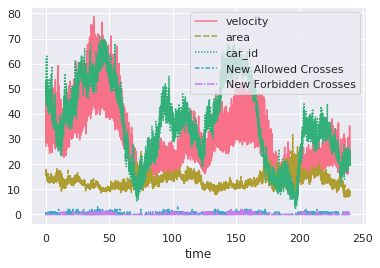

In [24]:
joined_crosses_correlation_table = final_table_sheet1.join(crosses_correlation_table)
display(joined_crosses_correlation_table)
correlation_crosses = joined_crosses_correlation_table.corr(method='pearson').to_numpy()
print(correlation_crosses)
ax = sns.lineplot(data=joined_crosses_correlation_table)
plt.show()
figure = ax.get_figure()    
figure.savefig('Correlation_2.png', dpi=400)

# Correlated factors with the Number of Forbidden Crosses (per second)

,time,velocity,area,car_id,New Allowed Crosses,New Forbidden Crosses,Time in seconds
0,0.12500,27.064516,15.251613,62,1.0,0.0,0.0
1,0.16667,31.039216,17.021569,51,0.0,0.0,0.0
2,0.20833,29.022222,16.666667,54,0.0,0.0,0.0
3,0.25000,29.195745,18.091489,47,0.0,0.0,0.0
4,0.29167,45.805660,17.856604,53,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5753,239.83333,24.452381,7.357143,21,0.0,0.0,239.0
5754,239.87500,25.128571,9.266667,21,0.0,0.0,239.0
5755,239.91667,24.490000,8.665000,20,0.0,0.0,239.0
5756,239.95833,22.895455,8.813636,22,0.0,0.0,239.0


,Average Velocity,Average Area,Number of cars,New Allowed Crosses,New Forbidden Crosses
Time in seconds,,,,,
0.0,32.970712,16.464125,51.380952,6.0,0.0
1.0,31.739935,14.051720,47.541667,3.0,0.0
2.0,31.796176,14.030936,44.666667,1.0,0.0
3.0,32.282326,13.925108,46.208333,4.0,0.0
4.0,31.981194,14.277099,46.291667,2.0,0.0
...,...,...,...,...,...
236.0,19.898889,7.716895,21.416667,0.0,2.0
237.0,19.703523,8.272359,21.333333,2.0,1.0
238.0,22.246228,8.216945,21.333333,1.0,1.0


[[ 1.         -0.50657517  0.78014929  0.44896773  0.30851207]
 [-0.50657517  1.         -0.4609226  -0.16001462 -0.32778844]
 [ 0.78014929 -0.4609226   1.          0.58914771  0.46023519]
 [ 0.44896773 -0.16001462  0.58914771  1.          0.34878824]
 [ 0.30851207 -0.32778844  0.46023519  0.34878824  1.        ]]


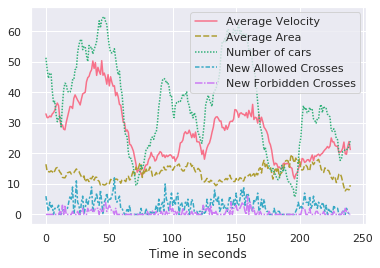

In [25]:
# per second statistics
per_second_joined_crosses_correlation_table = joined_crosses_correlation_table.reset_index()
for index, row in per_second_joined_crosses_correlation_table.iterrows():
    per_second_joined_crosses_correlation_table.loc[index,'Time in seconds'] = per_second_joined_crosses_correlation_table.loc[index,'time'].astype('int32')
display(per_second_joined_crosses_correlation_table)
d = {'velocity':'Average Velocity', 'area':'Average Area','car_id':'Number of cars', 'New Allowed Crosses':'New Allowed Crosses','New Forbidden Crosses':'New Forbidden Crosses','Time in seconds':'Time in seconds'}
final_per_second=per_second_joined_crosses_correlation_table.groupby('Time in seconds').agg({'velocity':'mean', 'area':'mean','car_id':'mean', 'New Allowed Crosses':'sum','New Forbidden Crosses':'sum'}).rename(columns=d)
display(final_per_second)
final_correlation_crosses = final_per_second.corr(method='pearson').to_numpy()
print(final_correlation_crosses)
ax = sns.lineplot(data=final_per_second)
plt.show()
figure = ax.get_figure()    
figure.savefig('Correlation_3.png', dpi=400)